# Rafael Rocket challenge - DataHack 2017

### Imports and environment

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import time

# model imports
from sklearn import model_selection
from sklearn.model_selection import train_test_split,KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import classification_report, log_loss
from sklearn.metrics import confusion_matrix
from pandas.plotting import scatter_matrix
from xgboost import XGBClassifier
from sklearn.grid_search import GridSearchCV

sns.set_style('white')
import random

%matplotlib inline

random.seed(12345)
seed = 12345  # for seeding individually

pd.options.display.max_columns = 100  # max columns to display

In [53]:
# choosing models to enumerate
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('ExtraTreesClassifier',ExtraTreesClassifier()))
models.append(('RandomForestClassifier',RandomForestClassifier()))
models.append(('GradientBoostingClassifier',GradientBoostingClassifier()))
models.append(('XGBClassifier',XGBClassifier()))

In [36]:
# work_folder = r"C:\Users\User\Downloads\DataHack-2017-master\DataHack-2017-master"
work_folder = r'E:\DataHack_2017'
folder_join = os.path.join
# test_sample = folder_join(work_folder, 'test_sample.csv')
test_sample = folder_join(work_folder, 'test.csv')
# train_sample = folder_join(work_folder, 'train_sample.csv')
train_sample = folder_join(work_folder, 'train.csv')

In [78]:
# data loading 

# saving two least common classes for later, for 'other' classification
data_with23_16 = pd.read_csv(train_sample)
data_no23_16 = data_with23_16[~data_with23_16['class'].isin([23,16])]  # removed 2 classes as other
train_data, test_data = train_test_split(data_no23_16,test_size=0.2,random_state=123)  

# TODO: add features to 23 and 16 later

# train_temp, test_data = train_test_split(data_no23_16,test_size=0.2,random_state=123)  # switched to 80%

# data_with23_16['class'].value_counts()
# train_data, cv_data = train_test_split(train_temp,test_size=0.25,random_state=135)     # 60%

# cv_data - cross validation (20%)
# test_data - 20%
# train_data - 60%


In [ ]:
def process_data(dataset):
    # parsing features and turnng them into vectors:
    qq = list(range(1, 211, 7))
    t_mat = train_data.iloc[:,qq].as_matrix()
    qq = list(range(2, 211, 7))
    x_mat = train_data.iloc[:,qq].as_matrix()
    qq = list(range(3, 211, 7))
    y_mat = train_data.iloc[:,qq].as_matrix()
    qq = list(range(4, 211, 7))
    z_mat = train_data.iloc[:,qq].as_matrix()
    qq = list(range(5, 211, 7))
    vx_mat = train_data.iloc[:,qq].as_matrix()
    qq = list(range(6, 211, 7))
    vy_mat = train_data.iloc[:,qq].as_matrix()
    qq = list(range(7, 211, 7))
    vz_mat = train_data.iloc[:,qq].as_matrix()


    # 3 matrices:
    ax_mat = np.gradient(vx_mat,0.5,axis=1)
    ay_mat = np.gradient(vy_mat,0.5,axis=1)
    az_mat = np.gradient(vz_mat,0.5,axis=1)
    
    # features:
    v_total = np.sqrt(np.power(vx_mat,2)+np.power(vy_mat,2)+np.power(vz_mat,2))
    a_total = np.sqrt(np.power(ax_mat,2)+np.power(ay_mat,2)+np.power(az_mat,2))
    vx_mean = np.nanmean(vx_mat,axis=1)
    vz_mean = np.nanmean(vz_mat,axis=1)
    v_mean = np.nanmean(v_total,axis=1)
    ax_mean = np.nanmean(ax_mat,axis=1)
    az_mean = np.nanmean(az_mat,axis=1)
    a_total_mean = np.nanmean(a_total,axis=1)
    z_mean = np.nanmean(z_mat,axis=1)
    vx_std = np.nanstd(vx_mat,axis=1)
    vy_std = np.nanstd(vy_mat,axis=1)
    vz_std = np.nanstd(vz_mat,axis=1)
    v_std = np.nanstd(v_total,axis=1)
    ax_std = np.nanstd(ax_mat,axis=1)
    ay_std = np.nanstd(ay_mat,axis=1)
    az_std = np.nanstd(az_mat,axis=1)
    a_total_std = np.nanstd(a_total,axis=1)
    y_std = np.nanstd(y_mat,axis=1)
    N_data = len(train_data)
    
    notnan = ~np.isnan(x_mat)
    p=np.zeros((N_data, 3))
    roots = np.zeros((N_data, 2))
    for i in range(N_data):
        p[i,:] = np.polyfit(x_mat[i,notnan[i,:]], z_mat[i,notnan[i,:]],2)
        roots[i]=np.roots(p[i])

    poly_range = np.abs(roots[:,1]-roots[:,0])

    poly_c0 = p[:,0]
    poly_c1 = p[:,1]
    poly_c2 = p[:,2]

    poly_maxz = poly_c2-np.power(poly_c1,2)/float(4)/poly_c0
    
    new_feat = pd.DataFrame({'z_mean': z_mean, 
                         'vx_mean': vx_mean, 'vz_mean': vz_mean, 'v_mean': v_mean,
                         'ax_mean':ax_mean,'az_mean':az_mean,'a_total_mean':a_total_mean,
                         'vx_std': vx_std, 'vz_std': vz_std, 'v_std': v_std,
                         'ax_std':ax_std,'az_std':az_std,'a_total_std':a_total_std, 
                         'poly_c0':poly_c0,'poly_c1':poly_c1,'poly_c2':poly_c2,
                         'poly_range':poly_range,'poly_maxz':poly_maxz,'class':target})
    
    # get first 5 seconds
    qq = list(range(1,71))
    X_raw = train_data.iloc[:,qq]
    X_new = new_feat.drop('class',axis=1)

    # X = X_raw.join(X_new)  # Not using RAW at all
    X = X_new
    y = target

    X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.15,random_state=1)
    
    return X_train, X_val, y_train, y_val



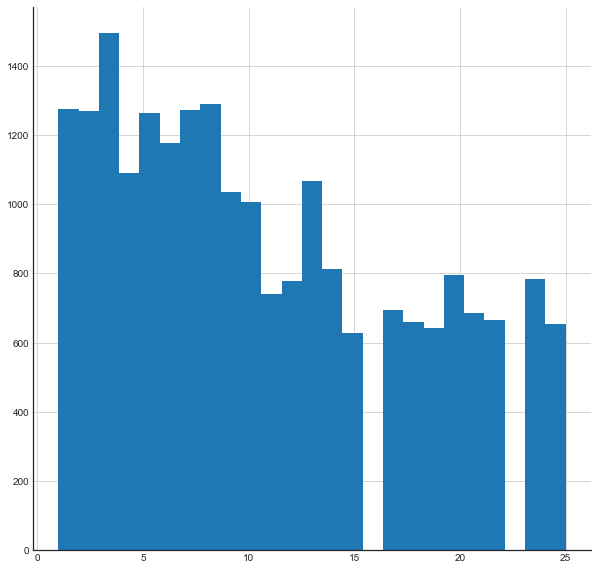

In [80]:
# print range(1, 213, 7)

# counting the rows for the different classes
target = train_data.loc[:,'class']
# print(target.value_counts())

# plot:
plt.figure(figsize=(10,10))
target.hist(bins=25)
sns.despine()


In [81]:
# parsing features and turnng them into vectors:
qq = list(range(1, 211, 7))
t_mat = train_data.iloc[:,qq].as_matrix()

qq = list(range(2, 211, 7))
x_mat = train_data.iloc[:,qq].as_matrix()

qq = list(range(3, 211, 7))
y_mat = train_data.iloc[:,qq].as_matrix()

qq = list(range(4, 211, 7))
z_mat = train_data.iloc[:,qq].as_matrix()

qq = list(range(5, 211, 7))
vx_mat = train_data.iloc[:,qq].as_matrix()

qq = list(range(6, 211, 7))
vy_mat = train_data.iloc[:,qq].as_matrix()

qq = list(range(7, 211, 7))
vz_mat = train_data.iloc[:,qq].as_matrix()



ax_mat = np.gradient(vx_mat,0.5,axis=1)
ay_mat = np.gradient(vy_mat,0.5,axis=1)
az_mat = np.gradient(vz_mat,0.5,axis=1)



# qq = list(range(1,71))
# print qq
# X = train_data.iloc[:,qq].as_matrix()
# print X

In [82]:
# print x_mat[0,:]
# for idx in range(11):
#     plt.scatter(t_mat[idx,:], z_mat[idx,:])
    
# dx_dt = np.gradient(x_mat,0.5,axis=0)
# # print dx_dt[0,:]

# v_total = np.sqrt(np.power(vx_mat,2)+np.power(vy_mat,2)+np.power(vz_mat,2))

# a_total = np.sqrt(np.power(ax_mat,2)+np.power(ay_mat,2)+np.power(az_mat,2))



# v_mean = np.nanmean(v_total,axis=1)

# vz_mean = np.nanmean(vz_mat,axis=1)

# ax_mean = np.nanmean(ax_mat,axis=1)

# az_mean = np.nanmean(az_mat,axis=1)

# a_total_mean = np.nanmean(a_total,axis=1)

# z_mean = np.nanmean(z_mat,axis=1)

# y_std = np.nanstd(y_mat,axis=1)

# N_data = len(train_data)


# print x_mat[0,:]
# for idx in range(11):
#     plt.scatter(t_mat[idx,:], z_mat[idx,:])
    
# dx_dt = np.gradient(x_mat,0.5,axis=0)
# print dx_dt[0,:]

v_total = np.sqrt(np.power(vx_mat,2)+np.power(vy_mat,2)+np.power(vz_mat,2))
a_total = np.sqrt(np.power(ax_mat,2)+np.power(ay_mat,2)+np.power(az_mat,2))
vx_mean = np.nanmean(vx_mat,axis=1)
vz_mean = np.nanmean(vz_mat,axis=1)
v_mean = np.nanmean(v_total,axis=1)
ax_mean = np.nanmean(ax_mat,axis=1)
az_mean = np.nanmean(az_mat,axis=1)
a_total_mean = np.nanmean(a_total,axis=1)
z_mean = np.nanmean(z_mat,axis=1)
vx_std = np.nanstd(vx_mat,axis=1)
vy_std = np.nanstd(vy_mat,axis=1)
vz_std = np.nanstd(vz_mat,axis=1)
v_std = np.nanstd(v_total,axis=1)
ax_std = np.nanstd(ax_mat,axis=1)
ay_std = np.nanstd(ay_mat,axis=1)
az_std = np.nanstd(az_mat,axis=1)
a_total_std = np.nanstd(a_total,axis=1)
y_std = np.nanstd(y_mat,axis=1)
N_data = len(train_data)



In [83]:
notnan = ~np.isnan(x_mat)
p=np.zeros((N_data, 3))
roots = np.zeros((N_data, 2))
for i in range(N_data):
    p[i,:] = np.polyfit(x_mat[i,notnan[i,:]], z_mat[i,notnan[i,:]],2)
    roots[i]=np.roots(p[i])
    
poly_range = np.abs(roots[:,1]-roots[:,0])



poly_c0 = p[:,0]
poly_c1 = p[:,1]
poly_c2 = p[:,2]

poly_maxz = poly_c2-np.power(poly_c1,2)/float(4)/poly_c0


In [ ]:
# new_feat = pd.DataFrame({'z_mean': z_mean, 'vz_mean': vz_mean, 'v_mean': v_mean, 'y_std':y_std, 'poly_c0':poly_c0,
#                          'poly_c1':poly_c1,'poly_c2':poly_c2,'poly_range':poly_range,'class':target})

# new_feat = pd.DataFrame({'z_mean': z_mean, 'vz_mean': vz_mean, 'ax_mean':ax_mean, 'az_mean':az_mean, 'v_mean': v_mean, 'y_std':y_std, 'poly_c0':poly_c0,
#                          'poly_c1':poly_c1,'poly_c2':poly_c2,'poly_range':poly_range,'class':target})

# new_feat = pd.DataFrame({'z_mean': z_mean, 'vz_mean': vz_mean, 'ax_mean':ax_mean, 'az_mean':az_mean,'a_total_mean':a_total_mean, 'v_mean': v_mean, 'poly_c0':poly_c0,
#                          'poly_range':poly_range,'poly_maxz':poly_maxz,'class':target})
# That was what we ran before

new_feat = pd.DataFrame({'z_mean': z_mean, 
                         'vx_mean': vx_mean, 'vz_mean': vz_mean, 'v_mean': v_mean,
                         'ax_mean':ax_mean,'az_mean':az_mean,'a_total_mean':a_total_mean,
                         'vx_std': vx_std, 'vz_std': vz_std, 'v_std': v_std,
                         'ax_std':ax_std,'az_std':az_std,'a_total_std':a_total_std, 
                         'poly_c0':poly_c0,'poly_c1':poly_c1,'poly_c2':poly_c2,
                         'poly_range':poly_range,'poly_maxz':poly_maxz,'class':target})

_ = scatter_matrix(new_feat)

y_std completely uniform, can ignore.
good correlations with class for: z_mean, v_mean, poly_range, maybe poly_c0.

In [ ]:
# get first 5 seconds
qq = list(range(1,71))
X_raw = train_data.iloc[:,qq]

# print X_raw.head(10)

# X_raw = pd.DataFrame({'x0':x_mat[:,0], 'y':y_mat, 'z':z_mat, 'vx':vx_mat, 'vy':vy_mat, 'vz':vz_mat})
# X_raw = pd.DataFrame({'x0':x_mat[:,0], 'y0':y_mat[:,0], 'z0':z_mat[:,0], 'vx0':vx_mat[:,0], 'vy0':vy_mat[:,0], 'vz0':vz_mat[:,0]})


X_new = new_feat.drop('class',axis=1)


# X = X_raw.join(X_new)  # Not using RAW at all
X = X_new

y = target

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.15,random_state=1)




### models

In [72]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score


# scoring_dict = {'accuracy': 'accuracy', 'f1_weighted': 'f1_weighted', 'precision_weighted': 'precision_weighted', 'recall': 'recall', 'average_precision': 'average_precision'}

# def getScores(estimator, x, y):
#     yPred = estimator.predict(x)
#     return (accuracy_score(y, yPred), 
#             precision_score(y, yPred, pos_label=3, average='weighted'), 
#             precision_score(y, yPred, pos_label=3, average='average'), 
#             recall_score(y, yPred, pos_label=3, average='macro'),
#             f1_score(y, yPred, pos_label=3, average='weighted'))

# def my_scorer(estimator, x, y):
#     scores_list = getScores(estimator, x, y)
#     return
    

In [87]:
# This is the snippet from the internet
# evaluate each model in turn
# scoring = 'accuracy'

scoring_dict = {'accuracy': 'accuracy', 'f1_weighted': 'f1_weighted', 'precision_weighted': 'precision_weighted', 'recall_weighted': 'recall_weighted'}
st_st_time = time.time()
seed = 12345
for name, model in models:
    st_time = time.time()
    print(f"Working on model {name}")
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    for scoring_type in scoring_dict:
        result = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring_type, n_jobs=-1)
        print(f"{name}: {scoring_type}: {result.mean():2.2f}, ({result.std():2.2f})")
#     results.append(cv_results)
#     names.append(name)
#     msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
#     print(msg)
#     print(classification_report(y_pred=pred,y_true=y_val))
#     pred_proba = gbc.predict_proba(X_val)
#     print('log_loss: {}'.format(log_loss(y_pred=pred_proba,y_true=y_val)))
    print(f"{name} took {time.time() - st_time:2.2f}")

print(f"The run took {time.time() - st_st_time:2.2f}")


Working on model LR
LR: accuracy: 0.40, (0.02)
LR: f1_weighted: 0.35, (0.01)
LR: precision_weighted: 0.39, (0.03)
LR: recall_weighted: 0.40, (0.02)
LR took 411.05
Working on model LDA
LDA: accuracy: 0.36, (0.01)
LDA: f1_weighted: 0.34, (0.01)
LDA: precision_weighted: 0.35, (0.02)
LDA: recall_weighted: 0.36, (0.01)
LDA took 56.90
Working on model KNN
KNN: accuracy: 0.35, (0.01)
KNN: f1_weighted: 0.34, (0.01)
KNN: precision_weighted: 0.35, (0.01)
KNN: recall_weighted: 0.35, (0.01)
KNN took 53.68
Working on model CART
CART: accuracy: 0.49, (0.02)
CART: f1_weighted: 0.49, (0.02)
CART: precision_weighted: 0.49, (0.02)
CART: recall_weighted: 0.49, (0.02)
CART took 61.55
Working on model NB
NB: accuracy: 0.22, (0.01)
NB: f1_weighted: 0.17, (0.01)
NB: precision_weighted: 0.19, (0.02)
NB: recall_weighted: 0.22, (0.01)
NB took 52.08
Working on model SVM
SVM: accuracy: 0.07, (0.01)
SVM: f1_weighted: 0.01, (0.00)
SVM: precision_weighted: 0.00, (0.00)
SVM: recall_weighted: 0.07, (0.01)
SVM took 107

KeyboardInterrupt: 

In [ ]:
# # This is the snippet from the internet
# # evaluate each model in turn

# # calculating score on f1_weighted and not accuracy
# %time
# st_st_time = time.time()
# results = []
# names = []
# scoring = 'f1_weighted'
# seed = 12345
# for name, model in models:
#     print(f"Now running on model: {name}")
#     st_time = time.time()
#     kfold = model_selection.KFold(n_splits=10, random_state=seed)
#     cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring, n_jobs=-1)
#     results.append(cv_results)
#     names.append(name)
#     msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
#     print(msg)
# #     print(classification_report(y_pred=pred,y_true=y_val))
# #     pred_proba = gbc.predict_proba(X_val)
# #     print('log_loss: {}'.format(log_loss(y_pred=pred_proba,y_true=y_val)))
#     print(f"{name} took {time.time() - st_time:2.2f}s")
# print(f"The whole enumeration took {time.time() - st_st_time:2.2f}s")


RandomForest got the best results (55%) on engineered features.
Now let's optimize the parameters:

## Random forest

In [114]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

pred = model.predict(X_val)
print(classification_report(y_pred=pred,y_true=y_val))
pred_proba = gbc.predict_proba(X_val)
print('log_loss: {}'.format(log_loss(y_pred=pred_proba,y_true=y_val)))

# feature_imp = pd.DataFrame(model.feature_importances_, index=X.columns, columns=["importance"])
# feat_imp_20 = feature_imp.sort_values("importance", ascending=False).head(20).index
# feat_imp_20



Index([u'ax_mean', u'poly_range', u'v_mean', u'poly_maxz', u'az_mean',
       u'a_total_mean', u'velX_9', u'posZ_3', u'vz_mean', u'posZ_2', u'posZ_4',
       u'posZ_0', u'posZ_7', u'z_mean', u'velX_8', u'poly_c0', u'posZ_1',
       u'velZ_3', u'velX_7', u'velZ_8'],
      dtype='object')

## Grid

In [ ]:
# TODO: grid
# on randomForest and ExtraTrees
param_grid = {'n_estimators': [5, 10, 15, 20, 30],
    'max_depth': [2, 5, 7, 9, 12, 14]
             }
clf = RandomForestClassifier()
grid_clf = model_selection.GridSearchCV(clf, param_grid, scoring='accuracy', cv=10)
grid_clf.fit(X_train, y_train)


In [ ]:
# # %%time

# gbc = XGBClassifier(objective='multi:softprob',
#                     learning_rate=0.2,
#                     subsample=0.7,
#                     colsample_bytree=0.9,
#                     colsample_bylevel=0.7,
#                     max_depth=5,
#                     nthread=4,
#                     n_estimators=50,
#                     seed=1234)

# gbc.fit(X_train,y_train)
# pred = gbc.predict(X_val)
# print(classification_report(y_pred=pred,y_true=y_val))
# pred_proba = gbc.predict_proba(X_val)
# print('log_loss: {}'.format(log_loss(y_pred=pred_proba,y_true=y_val)))

In [116]:
# # %%time

# gbc = XGBClassifier(objective='multi:softprob',
#                     learning_rate=0.2,
#                     subsample=0.7,
#                     colsample_bytree=0.9,
#                     colsample_bylevel=0.7,
#                     max_depth=8,
#                     nthread=4,
#                     n_estimators=50,
#                     seed=1234)

# gbc.fit(X_train,y_train)
# pred = gbc.predict(X_val)
# print(classification_report(y_pred=pred,y_true=y_val))
# pred_proba = gbc.predict_proba(X_val)
# print('log_loss: {}'.format(log_loss(y_pred=pred_proba,y_true=y_val)))

             precision    recall  f1-score   support

          1       0.92      0.92      0.92       145
          2       0.92      0.91      0.92       138
          3       0.45      0.59      0.51       152
          4       0.59      0.51      0.55       117
          5       0.47      0.47      0.47       139
          6       0.41      0.30      0.35       132
          7       0.45      0.55      0.50       146
          8       0.49      0.51      0.50       161
          9       0.30      0.24      0.27       131
         10       0.44      0.51      0.47       111
         11       0.56      0.35      0.43        85
         12       0.44      0.44      0.44        80
         13       0.59      0.60      0.60       133
         14       0.55      0.58      0.56       103
         15       0.60      0.52      0.56        62
         17       0.66      0.76      0.71        80
         18       0.27      0.32      0.29        66
         19       0.32      0.31      0.32   

In [ ]:
print v_mean
y_class = train_data.iloc[:,-1].as_matrix()
print train_data.iloc[:,-1].as_matrix()
plt.figure(1)
for idx in range(11):
    plt.scatter(t_mat[idx,:], z_mat[idx,:])
    
plt.figure(2)
for idx in range(11):
    plt.scatter(t_mat[idx,:], vz_mat[idx,:])

# print vx_mat[0,:]

[  861.04376964  2148.923032    1046.47697808  1399.18975142  3790.15396184
   937.34762028   334.50252791  1166.98663826   926.4386042   1953.3835557
   623.2201029 ]
[ 2.86380838  3.0788199   2.38553375  3.59066223  3.25316237  2.7329393
  1.90327152  1.90798713  3.9637277   2.63067801  3.71758076]


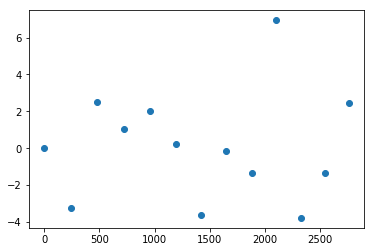

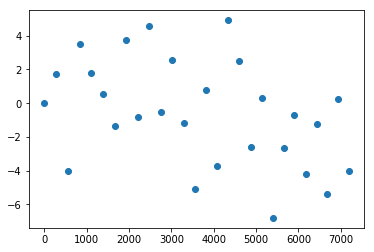

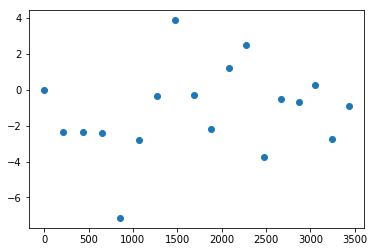

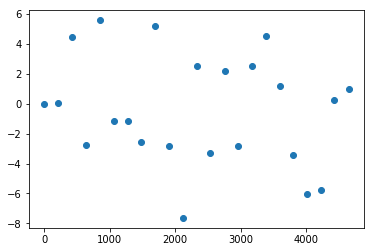

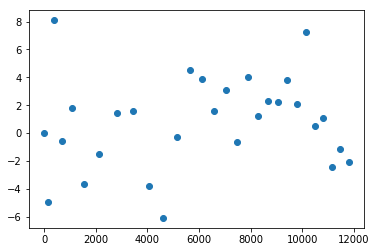

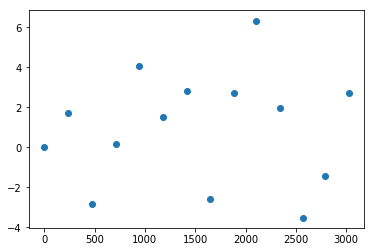

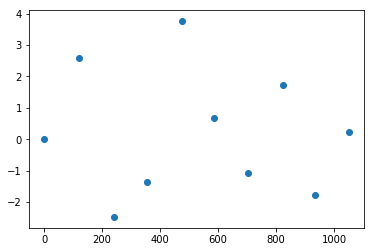

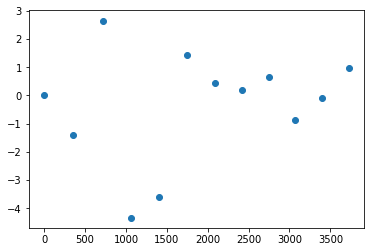

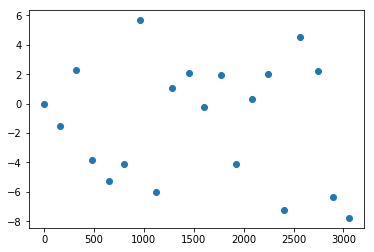

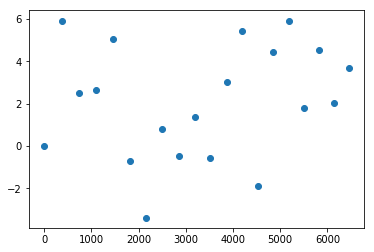

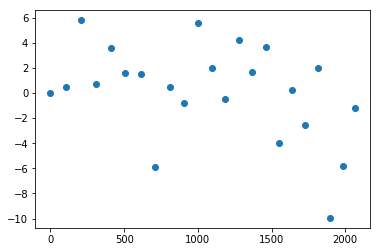

In [7]:
for idx in range(11):
    plt.figure()
    plt.scatter(x_mat[idx,:], y_mat[idx,:])
    
print np.nanstd(x_mat,axis=1)
print np.nanstd(y_mat,axis=1)

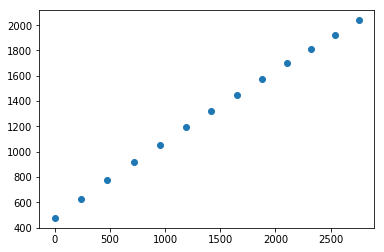

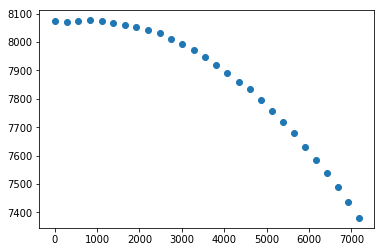

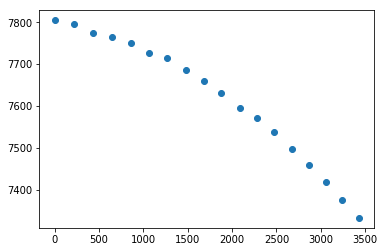

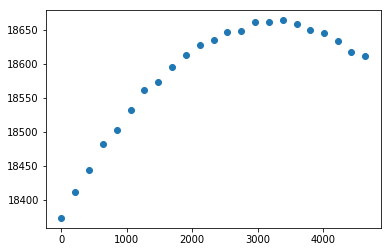

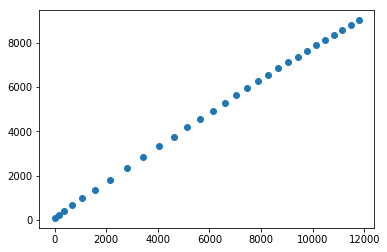

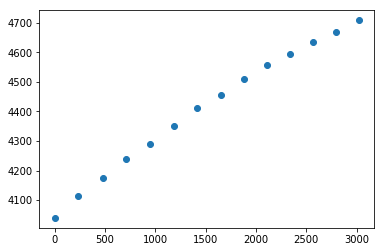

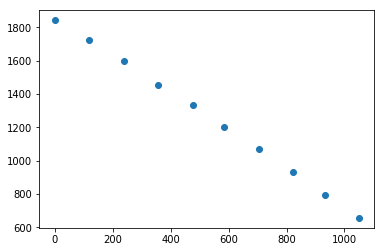

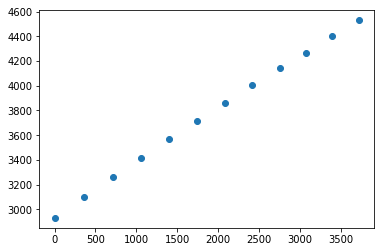

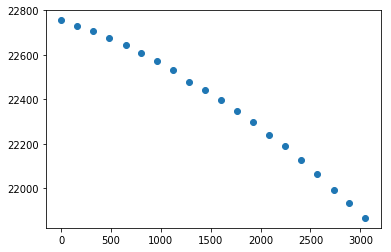

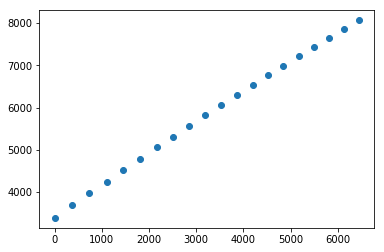

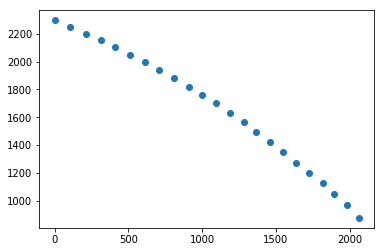

In [8]:
for idx in range(11):
    plt.figure()
    plt.scatter(x_mat[idx,:], z_mat[idx,:])

In [9]:
from curvature import curvature_splines
notnan = ~np.isnan(x_mat)
for idx in range(11):
    print curvature_splines(x_mat[idx,notnan[idx,:]], z_mat[idx,notnan[idx,:]],error=0.0001)


[-0.00536563 -0.00976    -0.01924507 -0.02157535  0.04906587 -0.08102378
  0.04131585 -0.04532799  0.06232212 -0.08508493  0.02279801  0.02323631
 -0.17857994]
[ 0.04615216  0.01468875 -0.00414074 -0.00610835 -0.05017162  0.0404003
 -0.01499144 -0.03048059  0.03102367 -0.06896841  0.03872248 -0.03433379
  0.01111228 -0.04213018  0.009951   -0.00585991  0.0358703  -0.07990841
  0.01703464 -0.01835035  0.02506439 -0.06960847  0.03282927  0.00753632
 -0.03064259 -0.02409843  0.00212498  0.04267587]
[ -3.62869434e-01  -4.42284243e-02   5.86001900e-02  -1.31435636e-04
  -9.55623931e-02   1.07326809e-01  -1.14361013e-01   2.22025638e-02
  -6.42800676e-03  -6.09298443e-02   9.62439877e-02  -8.27210285e-02
  -1.12090094e-02  -1.05280014e-02   2.11730555e-03  -3.20462224e-02
   2.03795365e-03   1.39700529e-01]
[-0.45266505 -0.00142855  0.05908229 -0.13260499  0.07998958  0.00911458
 -0.14062019  0.11258553 -0.0613735   0.00616693 -0.05692794  0.06915297
 -0.1095665   0.11154183 -0.10557064  0.0

[ 0.4432293  -0.29975551 -0.73885245 -0.31505908  0.05042303  0.07836286
  0.00267177  0.04522562  0.19499205  0.20583788  0.14161946  0.34919964
  0.20125916  0.30191129  0.40502252  0.36832789  0.66762393  0.34271478
  0.19410037 -0.02206019]


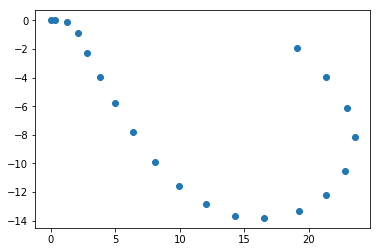

In [10]:
# example of curvatures from stackex:
a = np.array([ [  0.  ,   0.  ],[  0.3 ,   0.  ],[  1.25,  -0.1 ],[  2.1 ,  -0.9 ],[  2.85,  -2.3 ],[  3.8 ,  -3.95],[  5.  ,  -5.75],[  6.4 ,  -7.8 ],[  8.05,  -9.9 ],[  9.9 , -11.6 ],[ 12.05, -12.85],[ 14.25, -13.7 ],[ 16.5 , -13.8 ],[ 19.25, -13.35],[ 21.3 , -12.2 ],[ 22.8 , -10.5 ],[ 23.55,  -8.15],[ 22.95,  -6.1 ],[ 21.35,  -3.95],[ 19.1 ,  -1.9 ]])
plt.figure()
plt.scatter(a[:,0], a[:,1])
print curvature_splines(a[:,0], a[:,1],error=0.0001)


In [11]:
# notnan = ~np.isnan(x_mat)
np.set_printoptions(precision=5,suppress=True)
p=[]
for idx in range(11):
    p.append(np.polyfit(x_mat[idx,notnan[idx,:]], z_mat[idx,notnan[idx,:]],2))
    print p[idx]
    
for idx in range(11):
    print np.polyfit(x_mat[idx,notnan[idx,:]], z_mat[idx,notnan[idx,:]],1)
# p = np.polyfit(x_mat, z_mat, 2)


[  -0.00002    0.62502  478.63252]
[   -0.00002     0.02628  8066.69736]
[   -0.00003    -0.03586  7802.15057]
[    -0.00003      0.17585  18375.64203]
[ -0.00001   0.82548  96.1148 ]
[   -0.00002     0.29383  4040.59818]
[   -0.00009    -1.04028  1844.76585]
[   -0.00001     0.46874  2932.94828]
[    -0.00005     -0.1493   22756.10628]
[   -0.00001     0.79447  3390.38526]
[   -0.00014    -0.3879   2290.1037 ]
[   0.56478  504.23403]
[   -0.09583  8209.04537]
[   -0.13752  7857.7828 ]
[     0.04978  18468.80237]
[   0.75988  202.82057]
[    0.22072  4074.69436]
[   -1.13216  1859.15327]
[    0.42853  2955.85729]
[    -0.29215  22824.96474]
[    0.72494  3462.54344]
[   -0.68371  2389.56753]


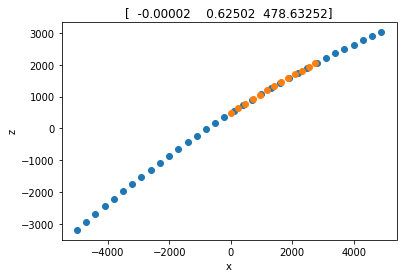

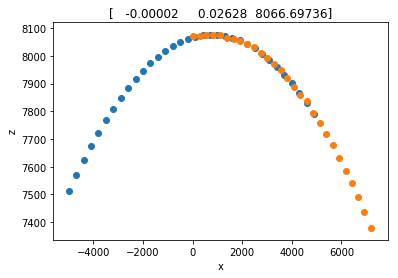

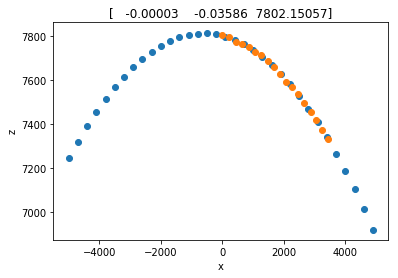

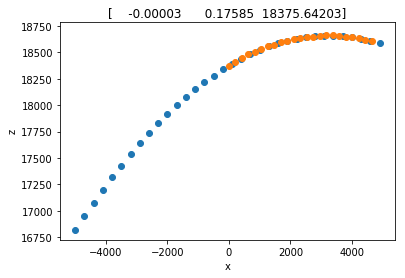

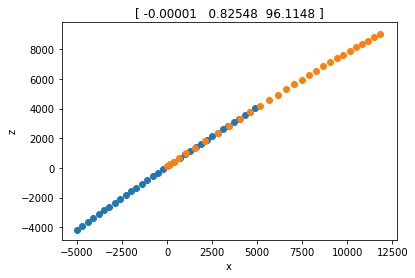

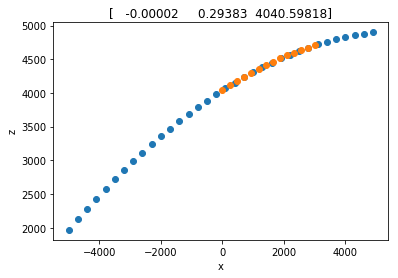

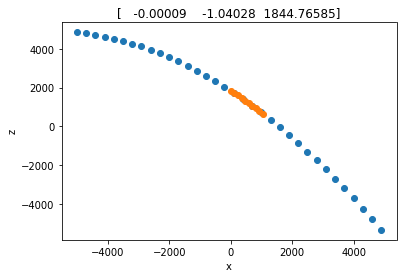

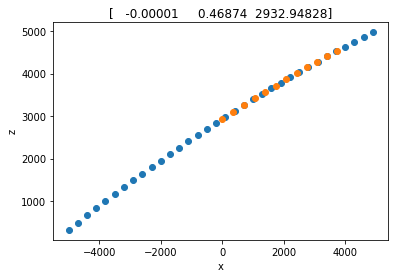

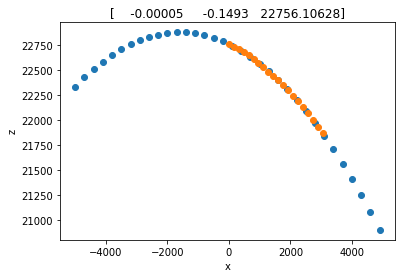

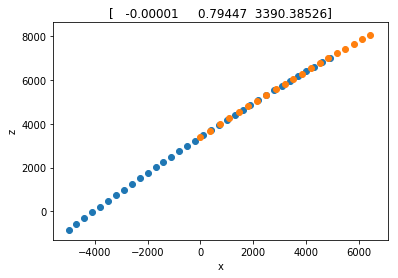

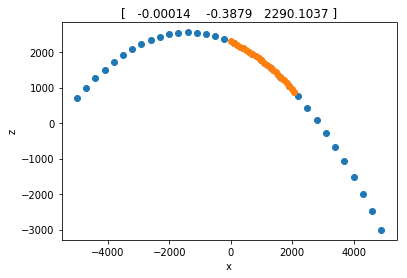

In [12]:


x_pol = range(-5000, 5000, 300)


for idx in range(11):
    x_pol = range(-5000, 5000, 300)
    plt.figure()
    
    # p=np.polyfit(x_mat[idx,notnan[idx,:]], z_mat[idx,notnan[idx,:]],2)
    z_pol = np.polyval(p[idx],x_pol)
    plt.scatter(x_pol,z_pol)
    # plt.gca().set_ylim(bottom=0)
    plt.scatter(x_mat[idx,:], z_mat[idx,:])
    plt.title(p[idx])
    plt.xlabel("x")
    plt.ylabel("z")

In [15]:

 # x_pol = range(-5000, 5000, 300)
for idx in range(11):
    roots=np.roots(p[idx])
    x_pol = range(int(min(roots)), int(max(roots)), 100)
    # x_pol = range(roots[idx,0], roots[idx,1], 100)
    plt.figure()
   
    
    # p=np.polyfit(x_mat[idx,notnan[idx,:]], z_mat[idx,notnan[idx,:]],2)
    # z_pol = np.polyval(p[idx],x_pol)
    plt.scatter(x_pol,z_pol)
    # plt.gca().set_ylim(bottom=0)
    plt.scatter(x_mat[idx,:], z_mat[idx,:])
    plt.title(p[idx])
    plt.xlabel("x")
    plt.ylabel("z")
    # print roots[idx]


ValueError: min() arg is an empty sequence

In [17]:
## Enumerate on classifiers
import matplotlib.pyplot as plt
# load dataset
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
# names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
# dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

In [92]:
### PCA
# train_data
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
print(pca.explained_variance_ratio_)

[ 0.85935008  0.12196621]


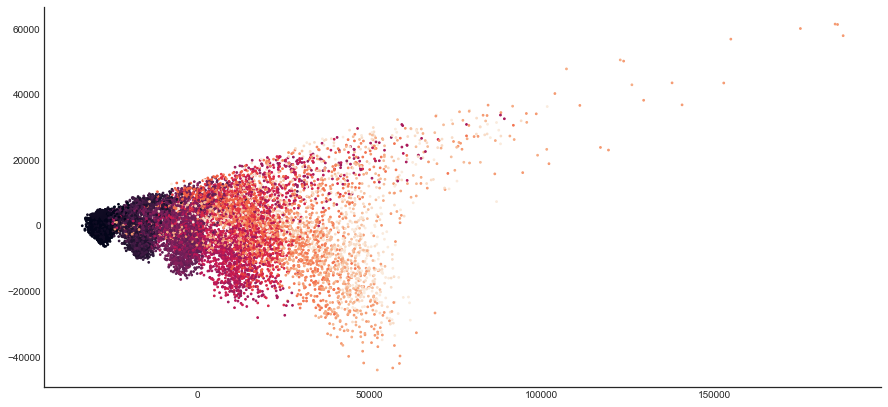

In [104]:
plt.figure(figsize=(15, 7))
p1 = [x[0] for x in X_pca]
p2 = [x[1] for x in X_pca]

colors = [int(i % 500) for i in y_train]
plt.scatter(p1, p2, c=colors, s=3)
sns.despine()

In [105]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_poly)
print(pca.explained_variance_ratio_)

NameError: name 'X_train_poly' is not defined